# CLIP
In this notebook, we create a *very* basic contrastive learning model. It consists of 45 main components:
- A label encoder
- An image encoder
- A projection head
- The model
- A contrastive loss


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

We have extracted the data loading utilities into a separate folder called `diffusion_models`.

In [2]:
# add diffusion models to path
import sys
sys.path.append('..')
from diffusion_models import utils

DATA_PATH = '../data/'
train_loader, test_loader = utils.get_mnist(32, DATA_PATH)

## Digit encoder
This is a simple convolutional network that takes a 28x28 image and outputs a 64-dimensional vector.

In [4]:
class DigitEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(392, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        return self.encoder(x)

## Label encoder
This is a simple feedforward network that takes a one-hot encoded label and outputs a 64-dimensional vector.

In [35]:
class LabelEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.GELU(),
            nn.Linear(16, 32),
            nn.GELU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        return self.encoder(x)

## Projection head
Take the output of the encoders and project them to the final embedding space. We define this separately so that we can use whatever encoders we want.

In [36]:
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim=64, projection_dim=128):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout()
        self.l2_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.l2_norm(x)
        return x

## The final model

In [37]:
class BasicCLIP(nn.Module):
    def __init__(self):
        super().__init__()

        self.image_encoder = DigitEncoder()
        self.label_encoder = LabelEncoder()
        self.temperature = nn.Parameter(torch.tensor(np.log(1/0.07)))

        self.W_i = ProjectionHead(64, 128)
        self.W_t = ProjectionHead(64, 128)

    def forward(self, imgs, labels):
        I_f = self.image_encoder(imgs)
        T_f = self.label_encoder(labels)

        I_e = self.W_i(I_f)
        T_e = self.W_t(T_f)

        # l2 normalize
        I_e = F.normalize(I_e, p=2, dim=1)
        T_e = F.normalize(T_e, p=2, dim=1)

        logits = I_e @ T_e.T * self.temperature

        return logits

## Contrastive loss function
We define a special loss function

In [38]:
def loss_function(logits, N):
    loss_i = F.cross_entropy(logits, torch.arange(N))
    loss_t = F.cross_entropy(logits.T, torch.arange(N))

    loss = (loss_i + loss_t)/2

    return loss

## Training

In [18]:
BATCH_SIZE = 32
clip = BasicCLIP()
optimizer = optim.Adam(clip.parameters(), lr=0.0001)

for epoch in range(20):
    for i, (imgs, targets, labels) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        logits = clip(imgs, labels)
        loss = loss_function(logits, BATCH_SIZE)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} Loss: {loss.item()}')

100%|██████████| 1875/1875 [00:14<00:00, 131.50it/s]


Epoch 1 Loss: 1.9742705821990967


100%|██████████| 1875/1875 [00:13<00:00, 134.03it/s]


Epoch 2 Loss: 1.7844693660736084


100%|██████████| 1875/1875 [00:13<00:00, 139.04it/s]


Epoch 3 Loss: 1.9029688835144043


100%|██████████| 1875/1875 [00:13<00:00, 137.46it/s]


Epoch 4 Loss: 1.6381258964538574


100%|██████████| 1875/1875 [00:14<00:00, 133.07it/s]


Epoch 5 Loss: 1.5152673721313477


100%|██████████| 1875/1875 [00:14<00:00, 133.77it/s]


Epoch 6 Loss: 1.551780104637146


100%|██████████| 1875/1875 [00:13<00:00, 137.79it/s]


Epoch 7 Loss: 1.6060250997543335


100%|██████████| 1875/1875 [00:14<00:00, 128.94it/s]


Epoch 8 Loss: 1.4457075595855713


100%|██████████| 1875/1875 [00:13<00:00, 136.91it/s]


Epoch 9 Loss: 1.6735202074050903


100%|██████████| 1875/1875 [00:14<00:00, 126.64it/s]


Epoch 10 Loss: 1.4219145774841309


100%|██████████| 1875/1875 [00:13<00:00, 139.20it/s]


Epoch 11 Loss: 1.5235974788665771


100%|██████████| 1875/1875 [00:14<00:00, 133.86it/s]


Epoch 12 Loss: 1.5458929538726807


100%|██████████| 1875/1875 [00:13<00:00, 137.76it/s]


Epoch 13 Loss: 1.3939533233642578


100%|██████████| 1875/1875 [00:13<00:00, 134.52it/s]


Epoch 14 Loss: 1.3812689781188965


100%|██████████| 1875/1875 [00:13<00:00, 136.54it/s]


Epoch 15 Loss: 1.2729465961456299


100%|██████████| 1875/1875 [00:13<00:00, 134.87it/s]


Epoch 16 Loss: 1.4988949298858643


100%|██████████| 1875/1875 [00:13<00:00, 136.52it/s]


Epoch 17 Loss: 1.4808372259140015


100%|██████████| 1875/1875 [00:13<00:00, 136.59it/s]


Epoch 18 Loss: 1.3340768814086914


100%|██████████| 1875/1875 [00:14<00:00, 131.13it/s]


Epoch 19 Loss: 1.2895631790161133


100%|██████████| 1875/1875 [00:13<00:00, 137.53it/s]

Epoch 20 Loss: 1.286539077758789


## Evaluation
We evaluate the clip model by comparing the images again an array from 0 to 9. We expect the probabilities to be highest for the correct digit. For example if the image is of a 7, we expect the 7th entry to be the highest.

In [42]:
# Evaluate the model
clip.eval()
predictions = []
real_labels = []

labels = torch.arange(10)
# need to be one-hot encoded
labels = F.one_hot(labels, num_classes=10).float()
with torch.no_grad():
    for (imgs, targets, true) in tqdm(test_loader):
        logits = clip(imgs, labels)
        probs = F.softmax(logits, dim=1)

        pred = torch.argmax(probs, dim=1)
        predictions.append(pred)

        true = torch.argmax(true, dim=1)
        real_labels.append(true)

predictions = torch.cat(predictions)
real_labels = torch.cat(real_labels)
        
        
(predictions == real_labels).sum().item()/len(predictions)       
        

100%|██████████| 313/313 [00:01<00:00, 191.92it/s]


In [45]:
(predictions == real_labels).sum().item()/len(predictions)


0.9818

98% is not terrible, but importantly we have also learned a useful shared embedding space.

What does the latent space of the image encoder look like?

In [54]:
# send the test digits through the encoder and get latent representations
latent_representations = []
test_labels = []
with torch.no_grad():
    for (imgs, targets, labels) in tqdm(test_loader):
        latent_representations.append(clip.image_encoder(imgs))
        labels = torch.argmax(labels, dim=1)
        test_labels.append(labels)


latent_representations = np.array(torch.cat(latent_representations)).squeeze()
test_labels = torch.cat(test_labels).numpy()

100%|██████████| 313/313 [00:01<00:00, 250.18it/s]


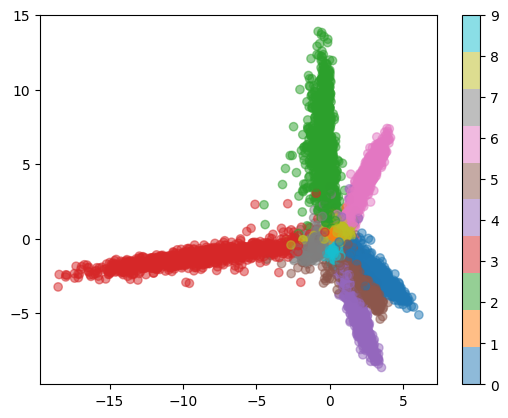

In [55]:
scaled = StandardScaler().fit_transform(latent_representations)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)
plt.scatter(pca_result[:,0], pca_result[:,1], c=test_labels, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.show()

# The logits for some examples
Here we get 10 examples from the training set and the corresponding labels. We then get the logits for these examples and plot them in a heatmap.

In [67]:
# get an example image from each class
example_images = []
example_labels = []
with torch.no_grad():
    for (imgs, targets, labels) in tqdm(test_loader):
        example_images.append(imgs[0])
        labels = torch.argmax(labels, dim=1)
        example_labels.append(labels[0].numpy())

example_images = torch.cat(example_images).numpy()
example_labels = np.array(example_labels)
# get one digit image from each class

images = []
for i in range(10):
    idx = np.where(example_labels == i)[0][0]
    images.append(example_images[idx])

100%|██████████| 313/313 [00:01<00:00, 294.49it/s]


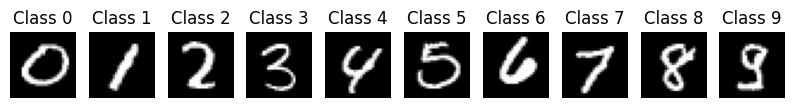

In [71]:
images = np.array(images)

# plot
fig, ax = plt.subplots(1, 10, figsize=(10, 5))
for i in range(10):
    ax[i].imshow(images[i].reshape(28, 28), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Class {i}')

plt.show()

In [72]:
one_hot_labels = np.zeros((10, 10))
one_hot_labels[np.arange(10), np.arange(10)] = 1

In [75]:
one_hot_labels.shape

(10, 10)

In [76]:
# get the logits
logits = clip(torch.tensor(images).unsqueeze(1), torch.tensor(one_hot_labels).float())

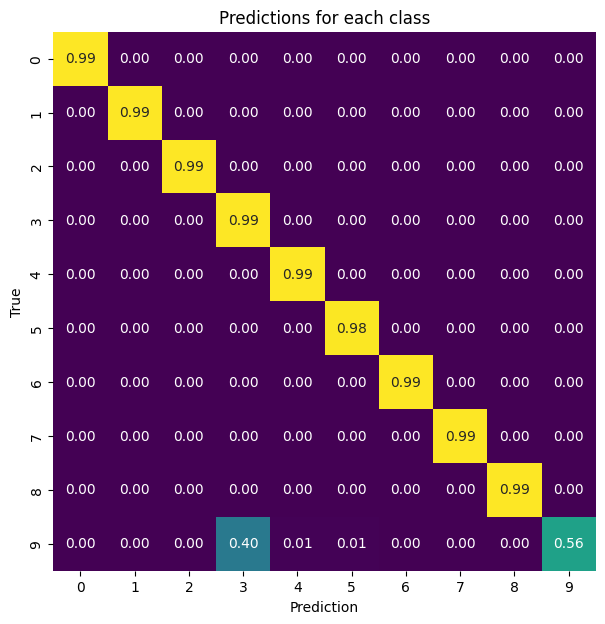

In [79]:
import seaborn as sns

# plot and force square
plt.figure(figsize=(7,7))

probs = F.softmax(logits, dim=1)
sns.heatmap(probs.detach().numpy(), cmap='viridis', cbar=False, annot=True, fmt='.2f')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Predictions for each class')
plt.show()


Not bad! The model struggled with this number 9, but looking at the image you can see that it _does_ sort of look like a 3, so understandable.

## Things to try:
1. Make a better label and/or image encoder
2. Make a bigger model!